# Cluster Expansion on Au-Cu Alloy Using CLEASE

## Introduction

In this tutorial, we show you show how to construct a Cluster Expansion (CE) model using CLEASE. We will look into Au-Cu alloys as it is a good example system to illustrate how one can use CE. It is known that Au-Cu alloy has 3 stable ordered phases at low temperatures: Au$_3$Cu, AuCu and AuCu$_3$. Thermodynamic quantities of the Au-Cu alloy calculated using CE-based Monte Carlo simulations are shown below. The three stable ordered phases can be seen in formation energy and free energy of formation plots.

<img src="thermo.png" style="width: 400px;"/>

It is noted that one can construct a CE model of Au-Cu alloy using around 30 to 40 DFT calculations, followed by rigorous Monte Carlo sampling (thousand atoms or more in a cell, millions of MC sampling per composition and temperature) to construct the plots above. As such an approach is not feasible in this tutorial due to the time constraint, we use the ``EMT`` calculator for calculating energies and search for the ground-state structures of the alloy in order to construct the formation energy plot of Au-Cu alloy at 0 K.

Note: Since we are using ``EMT`` calculator, we should expect some difference from the plots shown above. 


## Specify the concentration ranges of species


The first step in setting up CE in ASE is to specify the types of elements occupying each basis and their concentration ranges using the `Concentration` class. For AuCu alloys, we consider the entire composition range of Au$_x$Cu$_{1-x}$ where $0 \leq x \leq 1$. The `Concentration` object can be created as below because there is no restriction imposed on the concentration range.

In [3]:
from clease.settings import Concentration

conc = Concentration(basis_elements=[['Au', 'Cu']])
print("Done")

Done


A nested list is passed to the ``basis_elements`` argument because the constituting elements are specified per basis, and FCC (crystal structure of Au$_x$Cu$_{1-x}$ for all $0 \leq x \leq 1$) has only one basis. The initialization automatically creates a linear algebra representation of the default concentration range constraints. 

The equality condition of $A_\mathrm{eq} = \begin{bmatrix} \begin{bmatrix} 1 & 1 \end{bmatrix} \end{bmatrix}$ and $b_\mathrm{eq} = \begin{bmatrix} 1 \end{bmatrix}$ is created automatically. The condition represents the linear equations $A_\mathrm{eq} c_\mathrm{species} = b_\mathrm{eq}$, where the concentration list, $c_\mathrm{species}$, is defined as $c_\mathrm{species} = \begin{bmatrix} c_\mathrm{Au} & c_\mathrm{Cu} \end{bmatrix}$. The equality condition is then expressed as $c_\mathrm{Au} + c_\mathrm{Cu} = 1$, which specifies that elements Au and Cu constitute the entire basis (only one basis in this case). 

When no extra constraint is specified, the lower bound conditions, $A_\mathrm{lb} c_\mathrm{species} \geq b_\mathrm{lb}$, is _implicitly_ specified to be $A_\mathrm{lb} = \begin{bmatrix} \begin{bmatrix}1 & 0\end{bmatrix}, \begin{bmatrix}0 & 1\end{bmatrix} \end{bmatrix}$ and $b_\mathrm{lb} = \begin{bmatrix}0 & 0\end{bmatrix}$. The implicit lower bound conditions are expressed as $c_\mathrm{Au} \geq 0$ and $c_\mathrm{Cu} \geq 0$, which speicify that the concentrations of Au and Cu must be greater than or equal to zero.
 
You can check the values of $A_\mathrm{eq}$, $b_\mathrm{eq}$, $A_\mathrm{lb}$ and $b_\mathrm{lb}$ as below. Note that you will not see the lower bound conditions above as they are only used internally in the code.   

In [4]:
print("A_eq = {}\n"
      "b_eq = {}\n"
      "A_lb = {}\n"
      "b_lb = {}".format(conc.A_eq, conc.b_eq, conc.A_lb, conc.b_lb))

A_eq = [[1 1]]
b_eq = [1]
A_lb = []
b_lb = []


### A bit more advanced example


The AuCu system presented in this tutorial does not impose any concentration constraints. However, we demonstrate how one can impose extra constraints by using an example case where the concentration of interest is Au$_x$Cu$_{1-x}$ where $0 \leq x \leq 0.5$. The extra concentration constraint can be specified in one of three ways.

The first method is to specify the extra constraint using ``A_eq``, ``b_eq``, ``A_lb`` and ``b_lb``. For this particular case, the extra constraint is specified using ``A_lb`` and ``b_lb`` arguments as:

```python
from clease.settings import Concentration

conc = Concentration(basis_elements=[['Au', 'Cu']],
                     A_lb=[[2, 0]], b_lb=[1])
```

The second method is to specify the concentration range using formula unit strings. The `Concentration` class contains `set_conc_formula_unit()` method which accepts formula strings and variable range, which can be invoked as:

```python
from clease.settings import Concentration

conc = Concentration(basis_elements=[['Au', 'Cu']])
conc.set_conc_formula_unit(formulas=["Au<x>Cu<1-x>"],
                           variable_range={"x": (0, 0.5)})
```

The last method is to specify the concentration range each constituting species using `set_conc_ranges()` method. The lower and upper bound of species are specified in a nested list inthe same order as the ``basis_elements`` as:

```python
from clease.settings import Concentration

conc = Concentration(basis_elements=[['Au', 'Cu']])
conc.set_conc_ranges(ranges=[[(0, 0.5), (0.5, 1)]])
```

The above three methods yields the same results where $x$ is constrained to $0 \leq x \leq 0.5$.

## Specify CE settings

The next step is to specify the settings in which the CE model is constructed.
One of `CEBulk` or `CECrystal` classes is used to specify the
settings. `CEBulk` class is used when the crystal structure is one of
"sc", "fcc", "bcc", "hcp", "diamond", "zincblende", "rocksalt",
"cesiumchloride", "fluorite" or "wurtzite".

Here is how to specify the settings for performing CE on
Au$_x$Cu$_{1-x}$ for all $0 \leq x \leq 1$ on FCC lattice with a
lattice constant of 3.8 Å:

In [5]:
from clease.settings import CEBulk

db_name = "aucu_script.db"
settings = CEBulk(crystalstructure='fcc',
                  a=3.8,
                  supercell_factor=64,
                  concentration=conc,
                  db_name=db_name,
                  max_cluster_size=4,
                  max_cluster_dia=[7.0, 5.0, 4.5])
print("Done")

Done


`CEBulk` takes ``crystalstructure`` and ``a`` arguments which correspond to the type of crystal structure and lattice constant in Å, respectively. ``supercell_factor`` argument is used to set a threshold on the maximum size of the supercell for generating training structures. In case where one prefers to perform CE on a single, fixed size supercell, ``size`` parameter can be used instead of ``supercell_factor``. A list consisting of 3 integer values specifying the supercell size can be passed to the ``size`` arugment in that case (e.g., size = [3, 3, 3] for a $3 \times 3 \times 3$ supercell). 

The maximum size of clusters (i.e., number of atoms in a given cluster) and their maximum diameters are specified using ``max_cluster_size`` and ``max_cluster_dia``, respectively. As empty and 1-body clusters do not need
diameters in specifying the clusters, maximum diameters of clusters starting from 2-body clusters are specified in ``max_cluster_dia`` in ascending order.

The script above generates 1 entry to the database file with its name assigned as "primitive_cell". This entry is used to generate new structures and also to calculate their correlation functions. You can see the contents of the database file using the command below. 

In [4]:
!ase db aucu_script.db -c +name -L 0

id|age|user   |formula |calculator|energy|natoms| fmax|pbc| volume|charge|     mass| smax|name          
 1|12h|changai|Au      |          |      |     1|     |TTT| 13.718| 0.000|  196.967|     |primitive_cell
 2|12h|changai|Au      |          |      |     1|     |TTT| 13.718| 0.000|  196.967|     |Au1_0         
 3|12h|changai|Cu      |          |      |     1|     |TTT| 13.718| 0.000|   63.546|     |Cu1_0         
 4|12h|changai|Au15Cu10|          |      |    25|     |TTT|342.950| 0.000| 3589.959|     |Au3Cu2_0      
 5|12h|changai|Au48Cu16|          |      |    64|     |TTT|877.952| 0.000|10471.131|     |Au3Cu1_0      
 6|12h|changai|Au7Cu49 |          |      |    56|     |TTT|768.208| 0.000| 4492.520|     |Au1Cu7_0      
 7|12h|changai|AuCu3   |          |      |     4|     |TTT| 54.872| 0.000|  387.605|     |Au1Cu3_0      
 8|12h|changai|Au48Cu6 |          |      |    54|     |TTT|740.772| 0.000| 9835.671|     |Au8Cu1_0      
 9|12h|changai|Au12Cu18|          |      |    30|     |

You can also view the clusters using the following command. 

In [5]:
# you can ignore the warning message if it appears 
#settings.view_clusters()

There are several flavors of cluter expansion formalism in specifying the basis function for setting the site variable. Three types of basis functions are supported in CLEASE. The type of basis function can be selected by passing one of "polynomial", "trigonometric" and "binary_linear" to ``basis_function`` argument (default is "polynomial" if you do not specify). More information on each basis function can be found in the following articles.

"polynomial":
> Sanchez, J. M., Ducastelle, F. and Gratias, D. (1984)<br>
> ["Generalized cluster description of multicomponent systems"](https://doi.org/10.1016/0378-4371(84)90096-7)<br>
> Physica A: Statistical Mechanics and Its Applications, 128(1-2), 334-350.

"trigonometric":

> van de Walle, A. (2009)<br>
> ["Multicomponent multisublattice alloys, nonconfigurational entropy and other additions to the Alloy Theoretic Automated Toolkit"](https://doi.org/10.1016/j.calphad.2008.12.005)<br>
> Calphad, 33(2), 266-278.

"binary_linear":
> Zhang, X. and Sluiter M. (2016)<br>
> ["Cluster expansions for thermodynamics and kinetics of multicomponent alloys"](https://doi.org/10.1007/s11669-015-0427-x)<br>
> Journal of Phase Equilibria and Diffusion 37(1), 44-52.


## Generating initial pool of training structures 

The next step is to generate initial structures to start training the CE model. New structures for training
CE model are generated using `NewStructures` class, which contains several methods for generating structures. The initial pool of structures is generated using `generate_initial_pool()` method.

In [6]:
from clease.structgen import NewStructures

ns = NewStructures(settings=settings, generation_number=0,
                   struct_per_gen=10)
ns.generate_initial_pool()
print("Done")

Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.


Done


The ``NewStructures`` class takes setting instance and two additional arguments: 
   * ``generation_number`` is used to track at which point you generated the structures.
   * ``struct_per_gen`` specifies the maximum number of structures to be generated for that generation number.
   
The `generate_initial_pool()` method first generates one structure per concentration where the number of each constituing element is at its maximum/minimum. In the case of Au-Cu alloy, there are two extrema: Au and Cu. Consequently, `generate_initial_pool()` first generates 2 structures for training. It subsequently generates 8 random structures (remaining number of structures in generation 0) by calling `generate_random_structures()` method. 

Optionally, you can specify the size of the supercell of the random structures by passing an ``Atoms`` object to ``atoms`` argument. For example, you can use script like below to enforce the supercell size of the random structures to be $3 \times 3 \times 3$.

You can run the script below and see that 10 additional random structures with size $3\times3\times3$ are generated and automatically stored in the database. The fact that the number of atoms in the cell, `natoms`, is 27 indicates that you have $3 \times 3 \times 3$ cell as the primitve cell has only one atom. 

In [7]:
from clease.structgen import NewStructures
from ase.db import connect

db = connect(db_name)

# get template with the cell size = 3x3x3
template = db.get("name=primitive_cell").toatoms()*(3,3,3)

ns = NewStructures(settings=settings, generation_number=1,
                   struct_per_gen=10)
ns.generate_random_structures(atoms=template)

In [8]:
!ase db aucu_script.db -c +name -L 0

id|age|user   |formula |calculator|energy|natoms| fmax|pbc| volume|charge|     mass| smax|name          
 1|12h|changai|Au      |          |      |     1|     |TTT| 13.718| 0.000|  196.967|     |primitive_cell
 2|12h|changai|Au      |          |      |     1|     |TTT| 13.718| 0.000|  196.967|     |Au1_0         
 3|12h|changai|Cu      |          |      |     1|     |TTT| 13.718| 0.000|   63.546|     |Cu1_0         
 4|12h|changai|Au15Cu10|          |      |    25|     |TTT|342.950| 0.000| 3589.959|     |Au3Cu2_0      
 5|12h|changai|Au48Cu16|          |      |    64|     |TTT|877.952| 0.000|10471.131|     |Au3Cu1_0      
 6|12h|changai|Au7Cu49 |          |      |    56|     |TTT|768.208| 0.000| 4492.520|     |Au1Cu7_0      
 7|12h|changai|AuCu3   |          |      |     4|     |TTT| 54.872| 0.000|  387.605|     |Au1Cu3_0      
 8|12h|changai|Au48Cu6 |          |      |    54|     |TTT|740.772| 0.000| 9835.671|     |Au8Cu1_0      
 9|12h|changai|Au12Cu18|          |      |    30|     |

The generated structures include key-value pairs specifying their features. The genereated keys are:

| key            | description                                                                       |
|----------------|-----------------------------------------------------------------------------------|
|``gen``         |generation number                                                                  |
|``struct_type`` |"initial" for input structures, "final" for converged structures after calculation |
|``formula_unit``|reduced formula unit representation independent of the cell size                   |
|``name``        |name of the structure (``formula_unit`` followed by a number)                      |
|``converged``   |Boolean value indicating whether the calculation of the structure is converged     |
|``queued``      |Boolean value indicating whether the calculation is queued in the workload manager |
|``started``     |Boolean value indicating whether the calculation has started                       |

The ``queued`` and ``started`` keys are useful for tracking the status of the calculations submitted using a workload manager, but they do not serve any purpose in this tutorial. 

You can see the keys of the new entries in the database file by modifying the ``ase db`` command above. 

For example, one can view generation number and structure type by appending ``gen`` and ``struct_type`` to the command.


In [9]:
!ase db aucu_script.db -c +name,gen,struct_type,converged -L 0

id|age|user   |formula |calculator|energy|natoms| fmax|pbc| volume|charge|     mass| smax|name          |gen|struct_type|converged
 1|12h|changai|Au      |          |      |     1|     |TTT| 13.718| 0.000|  196.967|     |primitive_cell|   |           |         
 2|12h|changai|Au      |          |      |     1|     |TTT| 13.718| 0.000|  196.967|     |Au1_0         |  0|initial    |     True
 3|12h|changai|Cu      |          |      |     1|     |TTT| 13.718| 0.000|   63.546|     |Cu1_0         |  0|initial    |     True
 4|12h|changai|Au15Cu10|          |      |    25|     |TTT|342.950| 0.000| 3589.959|     |Au3Cu2_0      |  0|initial    |     True
 5|12h|changai|Au48Cu16|          |      |    64|     |TTT|877.952| 0.000|10471.131|     |Au3Cu1_0      |  0|initial    |     True
 6|12h|changai|Au7Cu49 |          |      |    56|     |TTT|768.208| 0.000| 4492.520|     |Au1Cu7_0      |  0|initial    |     True
 7|12h|changai|AuCu3   |          |      |     4|     |TTT| 54.872| 0.000|  387.605

## Running calculations on generated structures

We use `EMT` calculator to demonstrate how one can run calculations on the structures generated using CLEASE and update database with the calculation results for further evaluation of the CE model. Here is a simple example script that runs the calculations for all structures that are not yet converged.

In [7]:
from ase.calculators.emt import EMT
from ase.db import connect
from ase.constraints import UnitCellFilter
from ase.optimize import BFGS
from clease.tools import update_db

calc = EMT()
db = connect(db_name)

# Run calculations for all structures that are not converged.
for row in db.select(converged=False):
    print(f"Calculating the structure in row ID = {row.id}.")
    atoms = row.toatoms()
    atoms.calc = calc
    ucf = UnitCellFilter(atoms)
    opt = BFGS(ucf, logfile=None)
    opt.run(fmax=0.02)
    update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)
print("Done.")

Calculating the structure in row ID = 82.
Calculating the structure in row ID = 83.
Calculating the structure in row ID = 84.
Done.


CLEASE has `update_db` function in ``clease.tools`` to update the database entry with the calculation results. It automatically updates the key-value pairs of the initial structure entry as following:

| key               | description                                               |
|-------------------|-----------------------------------------------------------|
|``converged``      |True                                                       |
|``started``        |*empty*                                                    |
|``queued``         |*empty*                                                    |
|``final_struct_id``|ID of the DB entry containing the final converged structure|

The script also generates new entries containing calculation results (i.e., energy of the structures) with same ``name`` value as its original entry. You can check the entries in the database file to see the new entries containing the calculation results.

In [23]:
!ase db aucu_script.db -c +gen,struct_type,final_struct_id -L 0

id| age|user   |formula  |calculator|energy|natoms| fmax|pbc|  volume|charge|     mass| smax|gen|struct_type|final_struct_id
 1| 15h|changai|Au       |          |      |     1|     |TTT|  13.718| 0.000|  196.967|     |   |           |               
 2| 15h|changai|Au       |          |      |     1|     |TTT|  13.718| 0.000|  196.967|     |  0|initial    |             22
 3| 15h|changai|Cu       |          |      |     1|     |TTT|  13.718| 0.000|   63.546|     |  0|initial    |             23
 4| 15h|changai|Au15Cu10 |          |      |    25|     |TTT| 342.950| 0.000| 3589.959|     |  0|initial    |             24
 5| 15h|changai|Au48Cu16 |          |      |    64|     |TTT| 877.952| 0.000|10471.131|     |  0|initial    |             25
 6| 15h|changai|Au7Cu49  |          |      |    56|     |TTT| 768.208| 0.000| 4492.520|     |  0|initial    |             26
 7| 15h|changai|AuCu3    |          |      |     4|     |TTT|  54.872| 0.000|  387.605|     |  0|initial    |             27


## Evaluation of the CE model

We are now ready to evaluate a CE model constructed from the initial 10 calculations. The evaluation of the CE model is performed using ``Evaluate`` class, and it supports 3 different linear regression schemes: Bayesian Compressive Sensing (BCS), $\ell_1$ and $\ell_2$ regularization. 

We will be trying out $\ell_1$ and $\ell_2$ regularization schemes to see how they perform using the script below. The script is written to use $\ell_1$ regularization as a fitting scheme (i.e., fitting_scheme='l1'), and you can change the fitting scheme to $\ell_2$ simply by changing it to 'l2'.  



<IPython.core.display.Javascript object>


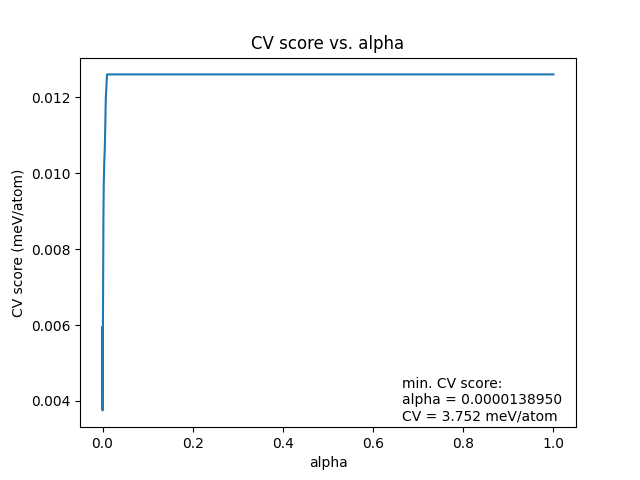

1.3894954943731361e-05


<IPython.core.display.Javascript object>


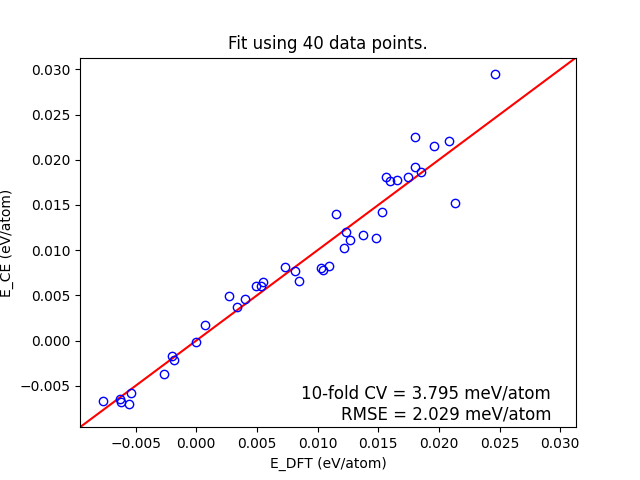

<IPython.core.display.Javascript object>


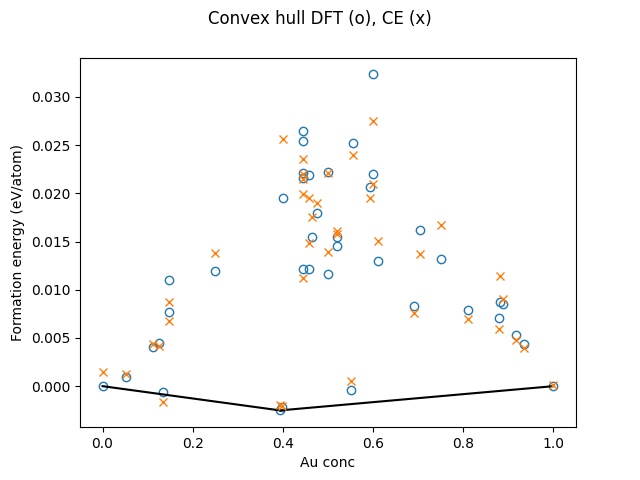

<IPython.core.display.Javascript object>


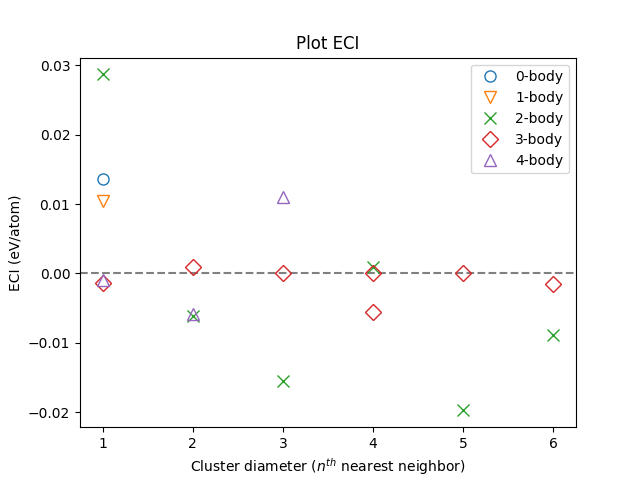

{'c0': 0.013612894046518765, 'c1_0': 0.010368886685734846, 'c2_d0000_0_00': 0.028687608576901762, 'c2_d0001_0_00': -0.00607279709492374, 'c2_d0002_0_00': -0.015498120980289597, 'c2_d0003_0_00': 0.0009105880572262187, 'c2_d0004_0_00': -0.01975044261832427, 'c2_d0005_0_00': -0.008933485188145601, 'c3_d0000_0_000': -0.0014017070116369096, 'c3_d0001_0_000': 0.0008710838237737069, 'c3_d0003_1_000': -0.005562760816603819, 'c3_d0005_0_000': -0.001479168533818809, 'c4_d0000_0_0000': -0.0009905573442439838, 'c4_d0001_0_0000': -0.0058106539754211916, 'c4_d0002_0_0000': 0.011068083450971407}


In [24]:
%matplotlib notebook
from clease import Evaluate
import clease.plot_post_process as pp

eva = Evaluate(settings=settings, fitting_scheme='l1', scoring_scheme='k-fold', nsplits=10)

# scan different values of alpha and return all values of alpha and its corresponding CV scores
alphas, cvs = eva.alpha_CV(alpha_min=1E-7, alpha_max=1.0, num_alpha=50)
pp.plot_cv(eva)

# set the alpha value to the one that yields the lowest CV score, and fit data using it.
idx = cvs.argmin()
alpha = alphas[idx]
print(alpha)
eva.set_fitting_scheme(fitting_scheme='l1', alpha=alpha)
eva.get_eci()
pp.plot_fit(eva)

# plot convex hull.
pp.plot_convex_hull(eva)

# plot ECI values, an emptry list is passed to ignore_sizes to plot all cluster sizes 
pp.plot_eci(eva)

# print dictionary containing cluster names and their ECIs
print(eva.get_eci_dict())

# save a dictionary containing cluster names and their ECIs
eva.save_eci(fname='cluster_name_eci_l1.json')

## Generation of probe structures for further training structures

You have now seen the initial cross validation (CV) score using 20 initial training structures. We can further train the CE model using more training structures to make it more robust. 

CLEASE supports 3 ways to generate more strucures. The first (and most obvious) is generating random structures as you have already done. The second method is to generate so called "probe structures" which differ the most from the existing training structures in the database. The third method is to generate ground-state structures predicted based on current CE model.

You can generate probe structures using the following script. Note that it internally uses simulated annealing algorithm which uses fictitious temperature values to maximize the difference in correlation function of the new structure. 

In [14]:
ns = NewStructures(settings=settings, struct_per_gen=10)
ns.generate_probe_structure()
print("Done")

Done


Once 10 additional structures are generated, you can re-run the script in "Running calculations on generated structures" section to calculate their energies. You should also run the script in "Evaluation of the CE model" section to evaluate the CV score of the model.

It is likely that the CV score of the model is sufficiently low (few meV/atom or less) at this point. 


## Generate ground-state structures

You can now genereate ground-state structures to construct convex-hull plot of formation energy. The script below generates ground-state structures with a cell size of $6\times6\times6$ at random compositions based on current CE model.

In [20]:
import json

# get template with the cell size = 6x6x6
template = db.get("name=primitive_cell").toatoms()*(6,6,6)

# import dictionary containing cluster names and their ECIs
with open('cluster_name_eci_l1.json') as f:
    eci = json.load(f)

ns = NewStructures(settings=settings, struct_per_gen=10)

ns.generate_gs_structure(atoms=template, eci=eci,
                         init_temp=2000, final_temp=1, 
                         num_temp=10, num_steps_per_temp=5000,
                         random_composition=True)
print("Done")

Done


Again, you should re-run the scripts in "Running calculations on generated structures" and "Evaluation of the CE model" sections to see the convex-hull plot and the latest CV score of the model. If you observe that the CV score is high (more than ~5 meV/atom), you may want to repeat running the script for generating ground-state structures. 

If you want to generate ground-state structures at the three concentrations in which stable ordered phase exist (Au$_3$Cu, AuCu, AuCu$_3$), you can alternatively run the scripts below.  

In [9]:
from ase.io import read
from ase.visualize import view 

# get templates of Au3Cu, AuCu, AuCu3 with the cell size = 6x6x6
au3cu = read('template_au3cu.traj')
aucu = read('template_aucu.traj')
aucu3 = read('template_aucu3.traj')

template_list = [au3cu, aucu, aucu3]

# visualize the templates
view(template_list)


In [26]:
import json

# import dictionary containing cluster names and their ECIs
with open('cluster_name_eci_l1.json') as f:
    eci = json.load(f)

ns = NewStructures(settings=settings, struct_per_gen=3)

ns.generate_gs_structure(atoms=template_list, eci=eci,
                         init_temp=2000, final_temp=1, num_temp=10,
                         num_steps_per_temp=5000,
                         random_composition=False)
print("Done")

Done


Feel free to change the scripts above to experiment how you can search ground-state structures and construct a convex-hull plot!

Note: if you have the converged CE model and found the ground-state structures in database already, the last script above will not be able to generate new ground-state structure as it already exists.

## Checking the stable ordered phases

The 3 stable ordered phases (Au$_3$Cu, AuCu and AuCu$_3$) are provided in this example, which you can visualize using the following script. 

In [27]:
from ase.visualize import view
from ase.io import read

struct = []
struct.append(read('Au3Cu1.xyz'))
struct.append(read('Au1Cu1.xyz'))
struct.append(read('Au1Cu3.xyz'))

view(struct)

After inspecting the provided structures, run the script below to visualize the minimum energy structures of Au$_3$Cu, AuCu and AuCu$_3$ that exists in your DB. Do they look the same or similar?

In [10]:
# find the minimum energy structures
Au3Cu1 = []
names = []
for row in db.select('formula_unit=Au3Cu1,struct_type=initial'):
    energy = db.get(id=row.final_struct_id).energy
    energy /= row.natoms
    Au3Cu1.append((row.name, energy))
Au3Cu1.sort(key=lambda x: x[1])
names.append(Au3Cu1[0][0])

Au1Cu1 = []
for row in db.select('formula_unit=Au1Cu1,struct_type=initial'):
    energy = db.get(id=row.final_struct_id).energy
    energy /= row.natoms
    Au1Cu1.append((row.name, energy))
Au1Cu1.sort(key=lambda x: x[1])
names.append(Au1Cu1[0][0])

Au1Cu3 = []
for row in db.select('formula_unit=Au1Cu3,struct_type=initial'):
    energy = db.get(id=row.final_struct_id).energy
    energy /= row.natoms
    Au1Cu3.append((row.name, energy))
Au1Cu3.sort(key=lambda x: x[1])
names.append(Au1Cu3[0][0])

print(names)

# view minimum energy structures
images = []
for name in names:
    atoms = db.get('name={},struct_type=initial'.format(name)).toatoms()
    images.append(atoms)
view(images)

['Au3Cu1_1', 'Au1Cu1_2', 'Au1Cu3_1']


## Analyzing Results
Did you manage to reproduce (i) the convex hull plot shown above and (ii) the ground-state structures of Au$_3$Cu, AuCu and AuCu$_3$? If you had some discrepancy, what do you think are the sources of discrepancy? 